- This demo uses the popular MNIST dataset, which consists of 70,000 hand written digits and is used for 
classification.

## Current best accuracy on postgres

### train_accuracy

- 99.64%

### test_accuracy

- 96.79%

### Parameters
- Hidden layers: [200,200], tanh activation, n_iterations=10, learning_rate_init=0.001, learning_rate_policy=constant, lambda=0.0001, tolerance=0

In [1]:
%load_ext sql
%sql postgresql://csloan@localhost:5432/postgres

u'Connected: csloan@postgres'

In [2]:
%%bash
# Note that these datasets are available from https://github.com/apache/incubator-madlib-site
gunzip -c ../data/mnist_train.sql.gz > ../data/mnist_train.sql
gunzip -c ../data/mnist_test.sql.gz > ../data/mnist_test.sql
psql -f ../data/mnist_train.sql
psql -f ../data/mnist_test.sql

DROP TABLE
CREATE TABLE
COPY 60000
DROP TABLE
CREATE TABLE
COPY 10000


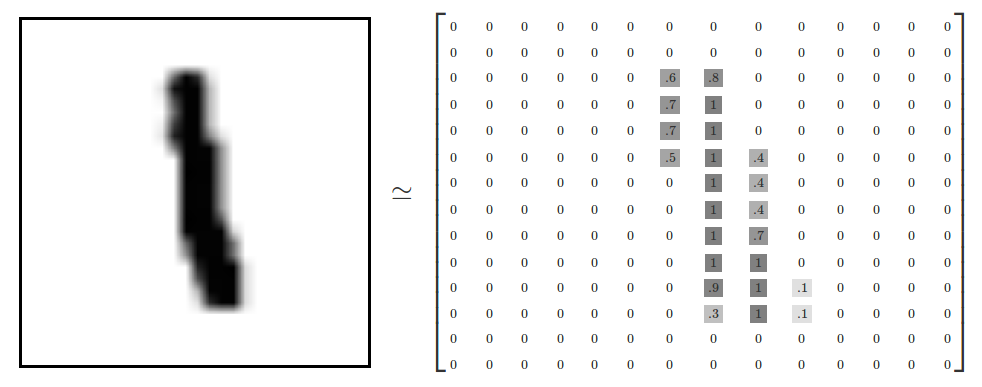

In [3]:
from IPython.display import Image
Image("../images/mlp-1.png")


In [4]:
%sql SELECT * FROM mnist_train LIMIT 1

1 rows affected.


y,x,id
5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 18, 18, 18, 126, 136, 175, 26, 166, 255, 247, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 36, 94, 154, 170, 253, 253, 253, 253, 253, 225, 172, 253, 242, 195, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 49, 238, 253, 253, 253, 253, 253, 253, 253, 253, 251, 93, 82, 82, 56, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 219, 253, 253, 253, 253, 253, 198, 182, 247, 241, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 156, 107, 253, 253, 205, 11, 0, 43, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 1, 154, 253, 90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 139, 253, 190, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 190, 253, 70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 241, 225, 160, 108, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 81, 240, 253, 253, 119, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 45, 186, 253, 253, 150, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 93, 252, 253, 187, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 249, 253, 249, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 46, 130, 183, 253, 253, 207, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 148, 229, 253, 253, 253, 250, 182, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 114, 221, 253, 253, 253, 253, 201, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 66, 213, 253, 253, 253, 253, 198, 81, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 171, 219, 253, 253, 253, 253, 195, 80, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 55, 172, 226, 253, 253, 253, 253, 244, 133, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 136, 253, 253, 253, 212, 135, 132, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1


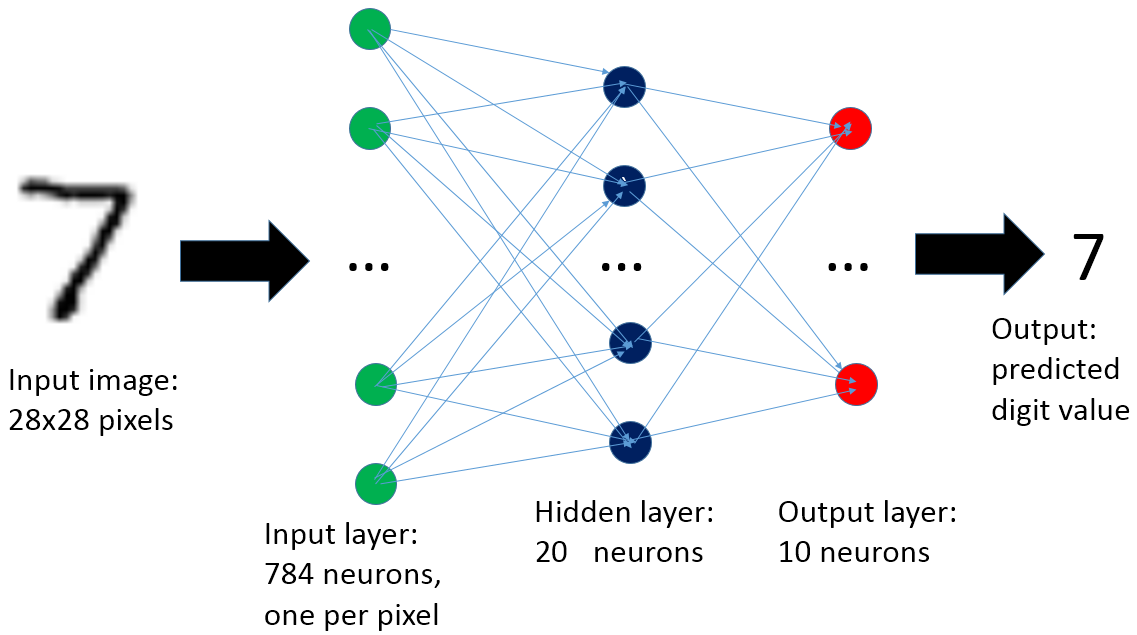

In [5]:
# From https://db-blog.web.cern.ch/blog/luca-canali/2016-07-neural-network-scoring-engine-plsql-recognizing-handwritten-digits
Image("../images/mlp-2.png")

In [30]:
%%sql

DROP TABLE IF EXISTS mnist_result_summary;
DROP TABLE IF EXISTS mnist_result;


SELECT madlib.mlp_classification(
    'mnist_train',               -- Source table
    'mnist_result',              -- Destination table
    'x',                         --  Indepented
    'y',                         -- Dependent
    ARRAY[100],                  -- Hidden layer sizes
    'learning_rate_init=0.001,
    n_iterations=1,
    learning_rate_policy=constant,
    lambda=0.0001,               -- Regularization
    tolerance=0',
    'tanh',                      -- Activation function
    '',                          -- No weights
    FALSE,                       -- No warmstart
    TRUE);                       -- Verbose

-- Select first 10 coefficients
SELECT coeff[1:10], loss, num_iterations FROM mnist_result;

Done.
Done.
1 rows affected.
1 rows affected.


coeff,loss,num_iterations
"[-0.0177185339494, 0.027813667813, -0.0164789113303, 0.0183163440532, -0.00206615430336, 0.0238662031211, 0.0316654529011, 0.0348023235447, -0.00928075956929, -0.000865806931865]",0.384551878395,1


In [31]:
%%sql

DROP TABLE IF EXISTS mnist_test_prediction;
SELECT madlib.mlp_predict(
    'mnist_result',
    'mnist_test',
    'id',
    'mnist_test_prediction',
    'response');
DROP TABLE IF EXISTS mnist_train_prediction;
SELECT madlib.mlp_predict(
    'mnist_result',
    'mnist_train',
    'id',
    'mnist_train_prediction',
    'response');

SELECT mnist_train.y AS actual, mnist_train_prediction.estimated_y AS estimated 
     FROM mnist_train_prediction inner join mnist_train
     on mnist_train.id=mnist_train_prediction.id LIMIT 20;

Done.
1 rows affected.
Done.
1 rows affected.
20 rows affected.


actual,estimated
5,5
0,0
4,4
1,1
9,9
2,2
1,1
3,3
1,1
4,4


In [32]:
%%sql
SELECT round(count(*)*100/60000.0,2) as train_accuracy_percent FROM
    (select mnist_train.y AS actual, mnist_train_prediction.estimated_y AS estimated 
     FROM mnist_train_prediction INNER JOIN mnist_train
     USING (id)) q
WHERE q.actual=q.estimated;

1 rows affected.


train_accuracy_percent
93.57


In [33]:
%%sql
SELECT round(count(*)*100/10000.0,2) AS test_accuracy_percent FROM
    (select mnist_test.y AS actual, mnist_test_prediction.estimated_y AS estimated
     FROM mnist_test_prediction INNER JOIN mnist_test
     USING (id)) q
WHERE q.actual=q.estimated;

1 rows affected.


test_accuracy_percent
92.97


In [26]:
%%latex

$\mathcal{O}(n\_data\_points * n\_features * n\_iterations * n\_nodes^2)$

<IPython.core.display.Latex object>